In [1]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# SENTIMENT ANALYSIS

Sentiment analysis is the process of analyzing digital text to determine if the emotional tone of the message is positive, negative, or neutral. Today, companies have large volumes of text data like emails, customer support chat transcripts, social media comments, and reviews. [Source](https://aws.amazon.com/what-is/sentiment-analysis/#:~:text=Sentiment%20analysis%20is%20the%20process,social%20media%20comments%2C%20and%20reviews.)

In this notebook, I will do sentiment analysis on One Piece Live Action IMDB Reviews. Using two sentiment analysis modules, Vader and Roberta.

## 1.Read data

In [2]:
df = pd.read_csv(r'D:\Dokumen\Hobi\Dataset\One Piece Review Dataset\reviews.csv')

# create id columns
df['id'] = df.index
df.head()

Title  \
0  Never seen the anime and still enjoyed it   
1     Not My Kind of Show. But This I Loved.   
2         I'm Shocked By How Good This Is...   
3             See Netflix?? You CAN do it...   
4                           WE WANT SEASON 2   

                                              Review              Date  \
0  I have to admit that I've never watched any of...  4 September 2023   
1  I'm a 60yo man & old school like the The Marin...  4 September 2023   
2  Every live action anime that I've briefly seen...  1 September 2023   
3  This is bar none one of the best live-action a...  4 September 2023   
4  Being a one piece fan myself, I was a bit inse...    31 August 2023   

   Rating  id  
0     8.0   0  
1     9.0   1  
2     9.0   2  
3    10.0   3  
4    10.0   4

This dataset contains user reviews and associated information for the live-action adaptation of the popular anime and manga series, "One Piece," as posted on the Internet Movie Database (IMDb). The live-action adaptation has generated significant attention and discussion among fans and critics alike. This dataset offers valuable insights into the reception and opinions of viewers regarding this adaptation. The reviews are till the Date 10 October 2023.

## 2.EDA

In [3]:
avg_rating = round(df['Rating'].mean(),2)
avg_rating

8.52

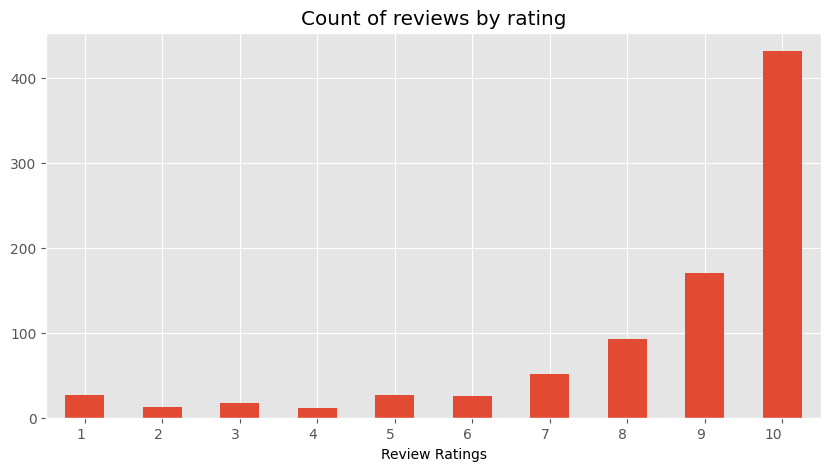

In [4]:
# Counts of review by rating
labels = [1,2,3,4,5,6,7,8,9,10]
ax = df['Rating'].value_counts().sort_index() \
    .plot(kind='bar', title='Count of reviews by rating', figsize=(10,5))
ax.set_xlabel('Review Ratings')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9], labels, rotation=0, ha='right')

plt.show()

Overall review for One Piece Live Action is positive. Mostly people give the show rating of 10, with mean 8.52.

## 3.Sentiment Analysis

### NLTK - VADER

VADER (Valence Aware Dictionary for Sentiment Reasoning) is an NLTK module that provides sentiment scores based on the words used.

In [5]:
from nltk.sentiment import  SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

In [6]:
example = df['Review'][42]
example

'While the live action adaptation of One Piece does not shy away from taking creative liberties, by removing or changing plot points, it still perfectly captures the essence and tone of the original story. The world is sufficiently strange and intriguing, and the special effects, mostly, do not feel out of place or distracting. A 90% score might seem a bit too high when compared to other well received shows, like Breaking Bad or the first few seasons of Game of Thrones, but rating OPLA for what it is: an adaptation of the One Piece manga, I can think of very few concrete changes to improve it, so by that metric it is indeed almost perfect.'

In [7]:
sia.polarity_scores(example)

{'neg': 0.041, 'neu': 0.778, 'pos': 0.181, 'compound': 0.944}

In [8]:
result = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    myId = row['id']
    result[myId] = sia.polarity_scores(text)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 878/878 [00:01<00:00, 474.28it/s]


In [9]:
vader_result = pd.DataFrame(result).T
vader_result = vader_result.reset_index().rename(columns={'index':'id'})
vader_result = vader_result.merge(df, how='left')
vader_result.head()

id    neg    neu    pos  compound  \
0   0  0.062  0.758  0.181    0.9204   
1   1  0.117  0.568  0.315    0.9935   
2   2  0.111  0.693  0.197    0.9888   
3   3  0.066  0.789  0.145    0.9814   
4   4  0.042  0.704  0.254    0.9824   

                                       Title  \
0  Never seen the anime and still enjoyed it   
1     Not My Kind of Show. But This I Loved.   
2         I'm Shocked By How Good This Is...   
3             See Netflix?? You CAN do it...   
4                           WE WANT SEASON 2   

                                              Review              Date  Rating  
0  I have to admit that I've never watched any of...  4 September 2023     8.0  
1  I'm a 60yo man & old school like the The Marin...  4 September 2023     9.0  
2  Every live action anime that I've briefly seen...  1 September 2023     9.0  
3  This is bar none one of the best live-action a...  4 September 2023    10.0  
4  Being a one piece fan myself, I was a bit inse...    31 August 2023    10.0

#### Vader EDA

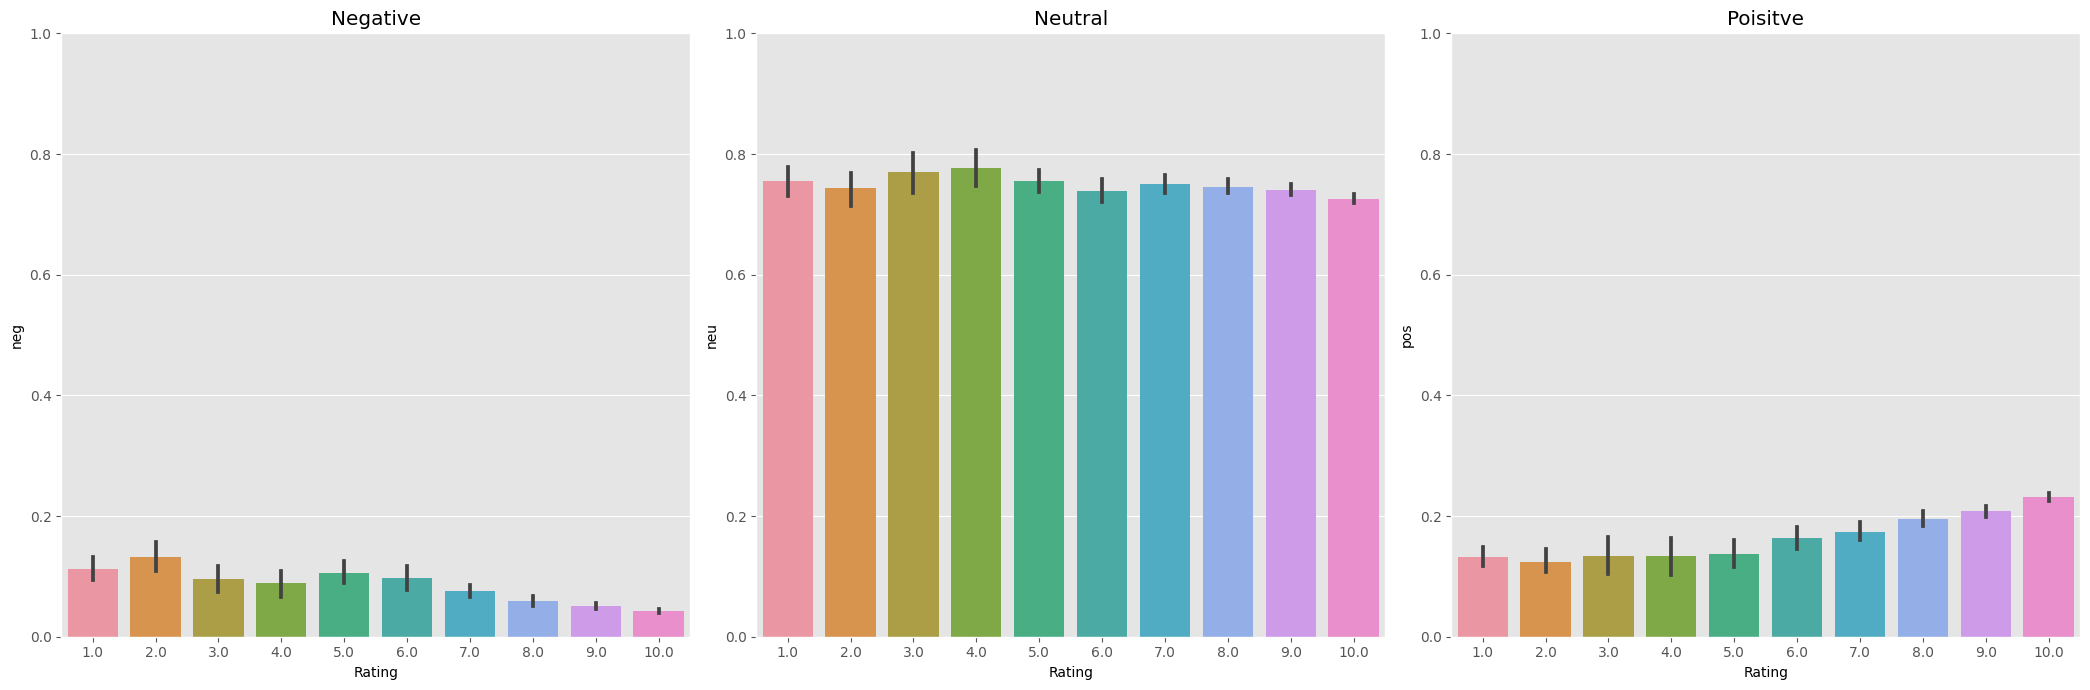

In [10]:
fig, axs = plt.subplots(1,3, figsize=(21,7))
sns.barplot(data=vader_result, x='Rating', y='neg', ax = axs[0])
sns.barplot(data=vader_result, x='Rating', y='neu', ax = axs[1])
sns.barplot(data=vader_result, x='Rating', y='pos', ax = axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Poisitve')
axs[0].set_ylim(0,1)
axs[1].set_ylim(0,1)
axs[2].set_ylim(0,1)
plt.tight_layout()
plt.show()

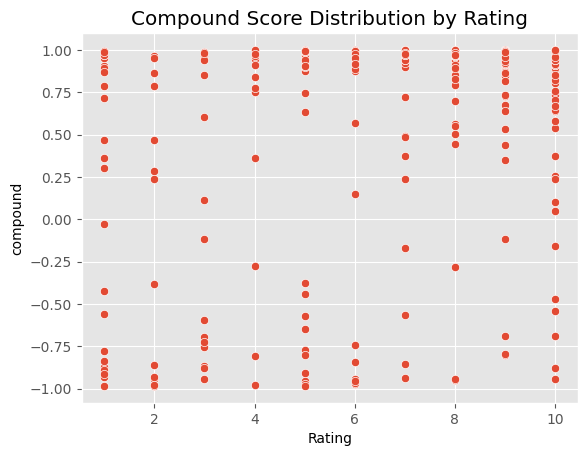

In [11]:
sns.scatterplot(data=vader_result, x='Rating', y='compound').set(title='Compound Score Distribution by Rating')

plt.show()

By using VADER some high rating review have negative compound sentiment score and vice versa. And from the barplot Vader mostly give the review neutral sentiment.

In [12]:
rating10_negcomp = vader_result[['id', 'neg','neu','pos','compound', 'Rating', 'Review']].loc[(vader_result.Rating == 10)&(vader_result.compound < 0)].reset_index()
rating10_negcomp

index   id    neg    neu    pos  compound  Rating  \
0    340  340  0.097  0.837  0.066   -0.6908    10.0   
1    356  356  0.159  0.718  0.122   -0.8771    10.0   
2    504  504  0.200  0.725  0.075   -0.9434    10.0   
3    539  539  0.076  0.853  0.071   -0.1607    10.0   
4    588  588  0.066  0.891  0.043   -0.4708    10.0   
5    659  659  0.137  0.743  0.120   -0.5434    10.0   

                                              Review  
0  This show is amazing I watched the Anime but t...  
1  It's not the best part of one piece. Not even ...  
2  Reading your review annoyed me so much that I ...  
3  Omg where do I start I am a fan of manga but n...  
4  What the actual heck. They did the impossible,...  
5  I have never written a review for anything on ...

In [13]:
rating10_negcomp['Review'][3]

"Omg where do I start I am a fan of manga but not a big one had some clue about this but not much and do boy this one is a piece of work what I afraid was that whenever a manga is brought to live adaptation it's always a mess but not in this case I was blown away by writing the action the sets the story the characters and overall package I thought I had nothing to watch let's give this a try and o boy I binged thru all without getting out of bed and believe me try this and see for yourself and I must say I am a regular fan of tv shows movies and pretty much seen everything so I'm not impressed easily 10/10."

In [14]:
rating1_poscomp = vader_result[['id','neg','neu','pos','compound', 'Rating', 'Review']].loc[(vader_result.Rating == 1)&(vader_result.compound > 0)].reset_index()
rating1_poscomp.head()

index   id    neg    neu    pos  compound  Rating  \
0    152  152  0.059  0.798  0.143    0.9506     1.0   
1    266  266  0.069  0.797  0.133    0.9537     1.0   
2    269  269  0.054  0.806  0.140    0.9020     1.0   
3    297  297  0.085  0.722  0.193    0.8955     1.0   
4    299  299  0.108  0.767  0.125    0.3621     1.0   

                                              Review  
0  Corny, boring, the actors don't care about the...  
1  The technical quality of this show is simply u...  
2  The Netflix live adaptation of "One Piece" fee...  
3  I don't know where to begin... This was a very...  
4  I've never watched the anime series by the sam...

In [217]:
rating1_poscomp.Review[0]

'Corny, boring, the actors don\'t care about their parts, or show any real interest in the show itself. I saw the first episode and after a while I started seeing the same thing over and over again, just the way the actors liked to pose for the camera, then depend on the special effects to make the show popular. Not to mention the way the characters look like they\'re cosplaying in their backyard and hosting a kid\'s show or something like "bear in the big blue house" especially when it comes to arlong. Believe me I don\'t know HOW this got so popular, or so much hype, but if you call it "bad" you\'re labeled the bad guy? I don\'t know, all I can say is EVEN Luffy doesn\'t punch like a girl with her thumbs up, and the way you can easily see the suspension strings on that actors should also tell you what to say about your "special effects" also, if you\'re praising THIS as a good LIVE action, then stop being so hard on the past live actions, because at least those guys tried, I mean c\'

### RoBERTa

In [218]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [219]:
from transformers import pipeline

In [220]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"    
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

sent_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, max_length=512, truncation=True)

In [221]:
def sent_roberta_pipeline(text):
    sent = sent_pipeline(text)
    sent_dict = {
    'label' : sent[0]['label'],
    'score' : sent[0]['score']
    }
    return sent_dict

In [222]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review']
        myId = row['id']
        res[myId] = sent_roberta_pipeline(text)
    except RuntimeError :
        print(f'Broker for id {myId}')

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 878/878 [08:38<00:00,  1.69it/s]


In [223]:
roberta_result = pd.DataFrame(res).T
labels = []

for i, row in tqdm(roberta_result.iterrows(), total=len(roberta_result)):
    if row['label'] == 'LABEL_0' :
        labels.append('negative')
    elif row['label'] == 'LABEL_2' :
        labels.append('positive')
    else :
        labels.append('neutral')

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 878/878 [00:00<00:00, 14136.55it/s]


In [224]:
roberta_result['label'] = labels
roberta_result = roberta_result.reset_index().rename(columns={'index':'id','label':'roberta_label', 'score':'roberta_score'})
roberta_result.head()

id roberta_label roberta_score
0   0      positive      0.800233
1   1      positive      0.948476
2   2      positive      0.665432
3   3      positive      0.483159
4   4      positive      0.982298

#### Roberta EDA

In [247]:
roberta_result = roberta_result.merge(df, how='left')

In [259]:
roberta_result['Rating'].value_counts()

10.0    432
9.0     171
8.0      93
7.0      52
5.0      27
1.0      27
6.0      26
3.0      17
2.0      13
4.0      12
Name: Rating, dtype: int64

In [302]:
positive_percent = round(roberta_result['roberta_label'].value_counts()[0]/ len(roberta_result) * 100,2)

print(f'Positive sentiment reviews percentage {positive_percent}%.')

Positive sentiment reviews percentage 79.84%.


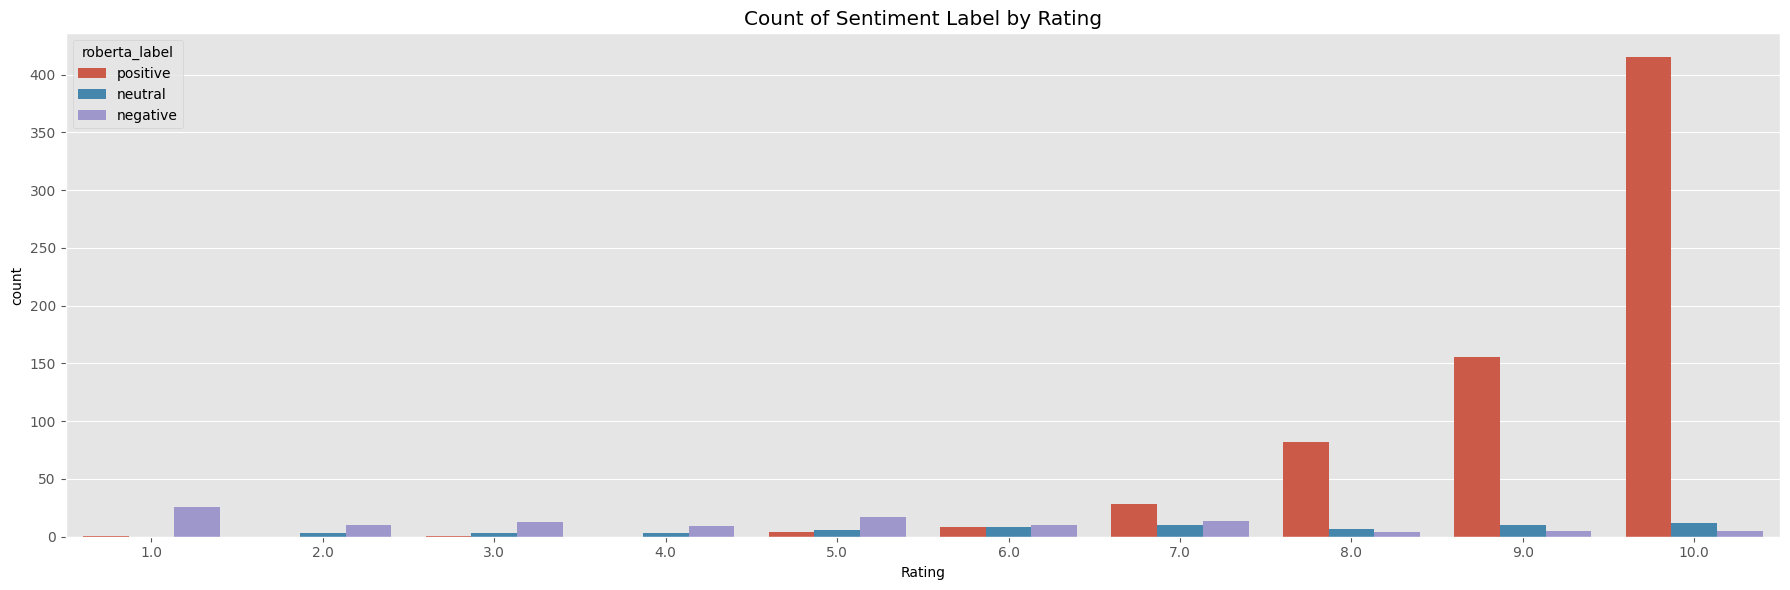

In [290]:
fig,ax= plt.subplots(figsize=(18,6))
sns.countplot(data=roberta_result, x='Rating', hue='roberta_label').set(title='Count of Sentiment Label by Rating')
plt.tight_layout()
plt.show()

Roberta have more confident than VADER in labeling the review sentiment. From the vader EDA, the sentiment mostly neutral while in Roberta the review sentiment mostly positive and most them have rating 7 and above. This corresponds to value counts of the rating given by the user.

### Analyzing Anomaly

#### High Rating Negative Label

In [281]:
highRating_negLabel = roberta_result.loc[(roberta_result.roberta_label == 'negative') & (roberta_result.Rating == 10)].reset_index()
highRating_negLabel

index   id roberta_label roberta_score  \
0    252  252      negative      0.698513   
1    356  356      negative      0.527701   
2    504  504      negative      0.963775   
3    539  539      negative      0.549573   
4    676  676      negative      0.581564   

                                               Title  \
0                            HATERS WILL ALWAYS HATE   
1         Not worth 10 but what a great adaptation !   
2                                    Cereo read this   
3  Girls Can Beat Boys But No Woman Can Beat A Man "   
4                      It is as real as it could be.   

                                              Review               Date  \
0  HATERS There are many types of haters in this ...   6 September 2023   
1  It's not the best part of one piece. Not even ...  10 September 2023   
2  Reading your review annoyed me so much that I ...   1 September 2023   
3  Omg where do I start I am a fan of manga but n...   4 September 2023   
4  Well people need to understand that that real ...   9 September 2023   

   Rating  
0    10.0  
1    10.0  
2    10.0  
3    10.0  
4    10.0

In [284]:
print(highRating_negLabel['Review'][0])
print(highRating_negLabel['roberta_score'][0])

HATERS There are many types of haters in this Live action of ONE Piece

number 1 is the OTHER ANIME LOVER the one that loves naruto, demon slayer, Aot, etc. They need to hate or blow some else's candle to make their anime shine and better in their perspective. People hate them because there is something that is much better than them. Come on guys, grow up. As an anime lover that loves One Piece, Naruto, AOT, to demon slayer to any other new anime. You need to clap and see the best in something. Rating a 1 really? Don't make me laugh. It seems you don't know anything about the production, the cinematography is lit, the props and costumes, the CGI, the characters, the effort and the acting. I know there is a lot of room for improvement. You won't get it on your first time. These perfect people who judge and need everything to be perfect.

AND FOR THE PEOPLE COMPLAINING ABOUT THE ACTING AND THE CAST. What do you want? An S class actor like Keanu Reeves, Robert Downey Jr., Leonardo? What a

What, I get from the review above. The user use 'hate' alot in his review. The user addressing the hater of the show. Which, made the review have a negative emotional tone. So, roberta correctly guess the sentiment of the review.

In [283]:
print(highRating_negLabel['Review'][1])
print(highRating_negLabel['roberta_score'][1])

It's not the best part of one piece. Not even close. As a real fan for almost 20 years, I loved the adaptation. But let's be honest, it's not worth 10. 8 would be a greater fit. But not because of the adaptation no. Because it's just not the best part of one piece that's all.

So 10 because the adaptation is well done but 8 because this part of the manga is good but not great.

The 8 episodes cover until episode 45 from the manga. And boy what happen next will be great.

My only fear is if each season covers let's say 50 episodes, knowing that there are today more than 1000+, with the assumption of one season a year, it's gonna be 20 years. And who wants luffy played by a middle aged man ?

They have 2 options. Either more than one a year, but knowing how long today 2 seasons are apart it seems almost impossible, either cutting a lot... which is possible as sometimes the manga is a little bit slow but I fear that some great moments don't make the cut.

So yeah...
0.5277014970779419


The review above, show the user opinion on early episode of one piece is not the best part of one piece and the user worries for the future of the show. We can see both opinions have negative emotional tone. So, roberta correctly guess the sentiment of the review.

#### Low Rating Positive Label

In [278]:
lowRating_posLabel = roberta_result.loc[(roberta_result.roberta_label == 'positive') & (roberta_result.Rating == 1)].reset_index()
lowRating_posLabel

index   id roberta_label roberta_score                Title  \
0    587  587      positive      0.442317  NO ONE MEANS NO ONE   

                                              Review              Date  Rating  
0  First of all ,,,I want to say ,,, " I don't kn...  1 September 2023     1.0

In [277]:
print(lowRating_posLabel['Review'][0])
print(lowRating_posLabel['roberta_score'][0])

First of all ,,,I want to say ,,, " I don't know whatever I am going to say is right or wrong but it is only my opinion,,,,may be others opinions are different from mine ,,,so please don't take it on your heart , it is my humble request..

One piece is a anime series,,,and it is still continues,,,as per my opinion no one can make or build one piece better than it's original anime version ðŸ˜ŠðŸ˜Š ,,,NO ONE MEANS NO ONE ,,,so please don't try it ,,,,

Listen,,,this dublicate one piece season 1 will be liked by those people who doesn't seen its original anime version,,,,, which is most realistic and entertaining series in the world.

The original anime version of the one piece series is not only serie it is a one type of emotion which can't be rebuilt or regenerate,,,

Ok this is all i want to say ...
0.4423171281814575


The user use smiley emoji in his review. Since roberta can extract sentiment from emoji, it is most likely roberta give this review a positive sentiment because of that. But also, the score is not that big only 0.44.

## 4.Conclusion

* Roberta has a better performance in distinguishing sentiment in reviews than Vader. This can be seen in the EDA of both algorithms, where Vader mostly gives the reviews neutral sentiment while Roberta confidently gives the reviews positive sentiment. 

* Based on Roberta result, One Pieve Live Action have a positive sentiment among its watcher with 79.84% of the reviews are positive. So, no surprise the show has high rating in IMDB with 8.4 (27/10/2023). [Source](https://www.imdb.com/title/tt11737520/)

* Roberta sometime label high rating reviews with negative labels and vice versa. But upon further investigation, roberta indeed correctly guessed the sentiment of the reviews. The user sometime writes a review with an emotional tone that is opposite to the rating scores.

* Later on, probably I will try to use Roberta to see a sentiment in social media like X, instagram, or Youtube.